In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
device = torch.device("cuda")

# Load HPCT Compression Model Model

In [3]:
from cheap.pretrained import CHEAP_shorten_1_dim_64

model = CHEAP_shorten_1_dim_64()
_ = model.to(device)

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 1 and 64 channel dimensions.


# Obtain Uncompressed $p(\text{sequence}, \text{structure})$ Embedding

In [4]:
# Load ESMFold Embedding-Only Model
from cheap.esmfold import esmfold_v1_embed_only

esmfold_embedder = esmfold_v1_embed_only()
_ = esmfold_embedder.to(device)

Creating ESMFold embedding only model...
ESMFold embedding only model created in 31.98 seconds


Alternatively, if the embeddings were already precomputed, this datamodule loaders the pre-computed embeddings:

In [5]:
# from cheap.datasets import H5DataModule

# dm = H5DataModule("/data/lux70/data/cath/shards")
# dm.setup()
# val_dataloader = dm.val_dataloader()
# batch = next(iter(val_dataloader))

# x, sequences, headers = batch

# from cheap.esmfold import batch_encode_sequences
# aatype, mask, _, _, _ = batch_encode_sequences(sequences)

In [6]:
sequences = [
    # >cath|current|12asA00/4-330
    "AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL",
    # >cath|current|132lA00/2-129
    "VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL",
    # >cath|current|153lA00/1-185
    "RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY",
]

In [7]:
res = esmfold_embedder.infer_embedding(sequences)
emb, mask = res['s'], res['mask']
emb, mask = emb.to(device), mask.to(device)

In [8]:
print(emb.shape)
print(mask.shape)

torch.Size([3, 327, 1024])
torch.Size([3, 327])


The sequences have been automatically padded to the longest sequence in the batch.
If you are running out of memory, consider trimming the sequences prior to this embedding inference operation.

In [9]:
sequence_lengths = mask.sum(dim=1)
print(sequence_lengths)

tensor([327, 124, 185], device='cuda:0')


## Sanity Check Predictions

In [10]:
from cheap.proteins import LatentToStructure, LatentToSequence

# !!!! important !!!!
# this implicitly creates the ESMFold model again, which might take up a lot of memory.
# Must explicitly call `.to(device)` on this wrapper API; models are by default loaded to the CPU. 
latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

# Similarly, this creates the sequence decoder, but it is much smaller than the structure decoder
latent_to_sequence = LatentToSequence()
latent_to_sequence = latent_to_sequence.to(device)

Creating ESMFold...
ESMFold model loaded in 36.91 seconds.


In [11]:
res = latent_to_sequence.to_sequence(emb); assert len(res) == 3

sanity_check_sequences = res[-1]
for i, s in enumerate(sanity_check_sequences):
    sanity_check_sequences[i] = s[:sequence_lengths[i]]

print(sanity_check_sequences)

['AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL', 'VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL', 'RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY']


In [12]:
from plaid.utils import calc_sequence_recovery

# sequence decoder gets perfect decoding accuracy:
for orig_s, sanity_s in zip(sequences, sanity_check_sequences):
    print(calc_sequence_recovery(orig_s, sanity_s))

1.0
1.0
1.0


In [13]:
# also get the structures -- we will visualize this together with the reconstructions later.
sanity_pdb_strs, sanity_raw_features = latent_to_structure.to_structure(emb, sequences)

## Massive Activations

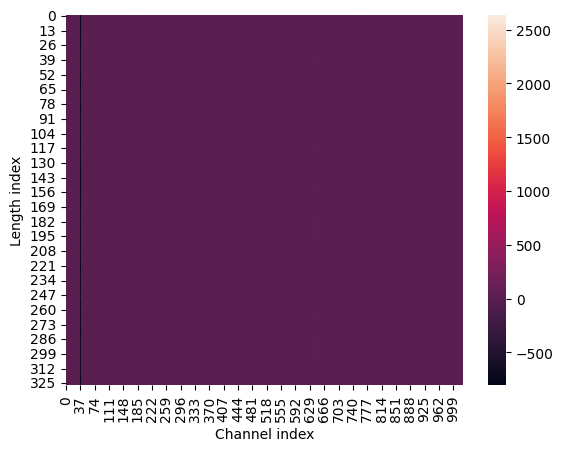

In [14]:
# just for fun, let's examine the massive activations:
import seaborn as sns
import matplotlib.pyplot as plt

_ = sns.heatmap(emb[0].cpu().numpy())
_ = plt.ylabel("Length index")
_ = plt.xlabel("Channel index")

torch.Size([1024])
2183.554931640625 -665.0863037109375


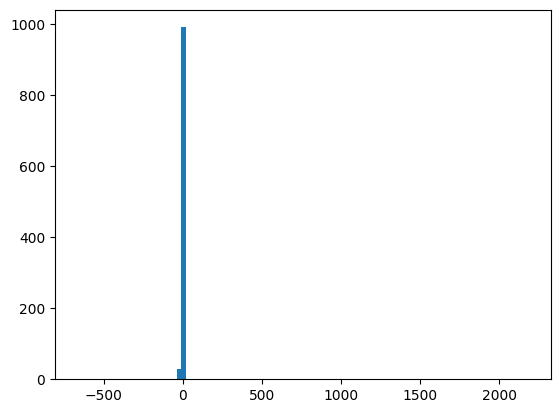

In [15]:
chan_means = emb.mean(dim=(0,1))
print(chan_means.shape)
print(chan_means.max().item(), chan_means.min().item())
_ = plt.hist(chan_means.cpu().numpy(), bins=100)

# Compressed representation

**!!! important !!!**
The compression model was trained with the assumption that the embedding was per-channel normalized, so we need to per-channel normalize it first.
TODO: build out a streamlined interface for doing this.

In [16]:
from cheap.utils import LatentScaler
latent_scaler = LatentScaler()

emb_scaled = latent_scaler.scale(emb)

In [17]:
# if only getting the compressed embeddings without requiring the reconstruction, can just use:
# compressed_representation, downsampled_mask = model(emb, mask, infer_only=True)
# but we would like to evaluate the reconstruction in this example.

x_recons, loss, log_dict, compressed_representation, downsampled_mask = model(emb_scaled, mask, infer_only=False)

In [18]:
print(compressed_representation.shape)
print(downsampled_mask.shape)

torch.Size([3, 327, 64])
torch.Size([3, 327])


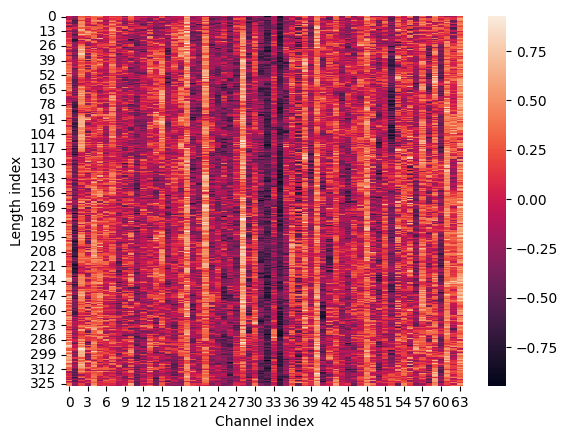

In [19]:
# for fun, let's look at the activations again
# notice that all values are bounded to between [-1, 1]
# and the channel and length have been compressed
_ = sns.heatmap(compressed_representation[0].cpu().numpy())
_ = plt.ylabel("Length index")
_ = plt.xlabel("Channel index")

In [20]:
recons_unscaled = latent_scaler.unscale(x_recons)

recons_sequence = latent_to_sequence.to_sequence(recons_unscaled, mask)[-1]
recons_pdb_strs, _ = latent_to_structure.to_structure(recons_unscaled, recons_sequence, mask=mask)

In [21]:
import py3Dmol

for i in range(len(recons_pdb_strs)):
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(sanity_pdb_strs[i])
    view.addModelsAsFrames(recons_pdb_strs[i])
    view.setStyle({"model": 0}, {"cartoon": {"color": "gray", "opacity": 0.7}})
    view.setStyle({"model": 1}, {"cartoon": {"color": "red", "opacity": 0.9}})
    view.zoomTo()
    view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.